In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import circlify
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
def import_files(folder_path):
    merged_df = pd.DataFrame()

    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        
        if os.path.isdir(subdir_path):
            ano = subdir

            for file_name in os.listdir(subdir_path):
                if file_name.endswith('.xlsx'):
                    file_path = os.path.join(subdir_path, file_name)

                    empresa = file_name.split(' - ')[-1].split('.')[0]

                    df = pd.read_excel(file_path)

                    df['Ano'] = ano
                    df['Empresa'] = empresa

                    merged_df = pd.concat([merged_df, df], ignore_index=True)

    return merged_df

In [3]:
folder_path = 'Dados_Substituicao'
substituicao = import_files(folder_path)
substituicao.head()

,LOCAL,DATA.OC,SITUAÇÃO,FABRICANTE,DATA_FABRICAÇÃO,FASES,CLASSE.DE.TENSÃO,POTÊNCIA,Ano,Empresa
0,RURAL,01/01/2023,QUEIMADO,NaN,NaN,INVALIDO,0.0,0.0,2023,E8
1,RURAL,01/01/2023,QUEIMADO,NaN,NaN,INVALIDO,0.0,0.0,2023,E8
2,RURAL,01/01/2023,AVARIADO,NaN,NaN,INVALIDO,0.0,0.0,2023,E8
3,RURAL,02/01/2023,QUEIMADO,NaN,NaN,INVALIDO,0.0,0.0,2023,E8
4,RURAL,02/01/2023,QUEIMADO,NaN,NaN,INVALIDO,0.0,0.0,2023,E8


In [4]:
folder_path = 'Dados_Parque'
parque = import_files(folder_path)
parque.head()

,ANO,MES,LOCAL,FASES,CLASSE.DE.TENSÃO,POTÊNCIA,PARQUE.INSTALADO,Ano,Empresa
0,2023,1,RURAL,MONO,11.4,5.0,53,2023,E2
1,2023,1,RURAL,MONO,11.4,10.0,10,2023,E2
2,2023,1,RURAL,MONO,11.4,15.0,37,2023,E2
3,2023,1,RURAL,MONO,11.4,25.0,11,2023,E2
4,2023,1,RURAL,TRI,11.4,15.0,10,2023,E2


In [5]:
clima = pd.read_csv('Dados_Climaticos.csv')
clima.head()

,Empresa,Regional,Ano,Mes,Chuva,Raio(NS)
0,E1,NaN,2021,1,165.0,2333.0
1,E1,NaN,2021,2,349.0,7761.0
2,E1,NaN,2021,3,272.0,4547.0
3,E1,NaN,2021,4,158.0,4540.0
4,E1,NaN,2021,5,54.0,597.0


In [6]:
parque_2022 = parque[(parque['ANO'] == 2022) & (parque['MES'] == 12)]
parque_2022_empresa = parque_2022.groupby('Empresa')['PARQUE.INSTALADO'].sum().reset_index()
parque_2022_empresa.columns = ['Empresa', 'Parque']
parque_2022_empresa

,Empresa,Parque
0,E1,39080
1,E2,70813
2,E3,51060
3,E4,49528
4,E5,71095
5,E6,85325
6,E7,127175
7,E8,89832
8,E9,226011


In [7]:
substituicao_2022 = substituicao[(substituicao['Ano'] == '2022')]
substituicao_2022_empresa = substituicao_2022['Empresa'].value_counts().reset_index()
substituicao_2022_empresa.columns = ['Empresa', 'Falhas']
substituicao_2022_empresa

,Empresa,Falhas
0,E9,3230
1,E8,2503
2,E6,2247
3,E7,2156
4,E5,1319
5,E1,985
6,E3,812
7,E4,688
8,E2,616


In [8]:
ist_un = parque_2022_empresa.merge(substituicao_2022_empresa, on="Empresa", how="left")
ist_un['ist_un'] = ist_un['Falhas'] / ist_un['Parque'] 
ist_un

,Empresa,Parque,Falhas,ist_un
0,E1,39080,985,0.025205
1,E2,70813,616,0.008699
2,E3,51060,812,0.015903
3,E4,49528,688,0.013891
4,E5,71095,1319,0.018553
5,E6,85325,2247,0.026335
6,E7,127175,2156,0.016953
7,E8,89832,2503,0.027863
8,E9,226011,3230,0.014291


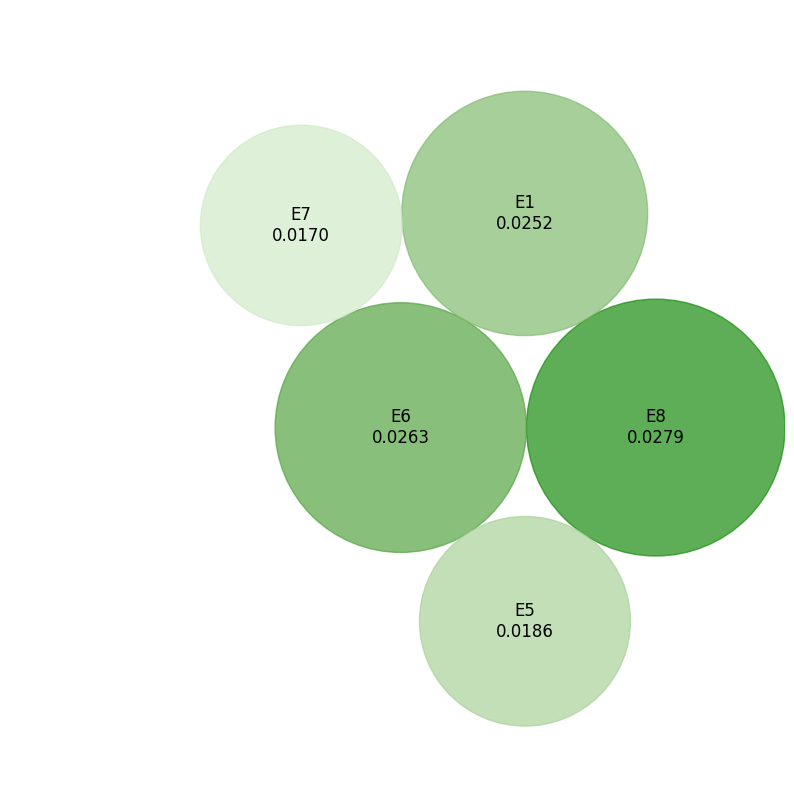

In [9]:
ist_un.sort_values(by='ist_un', ascending=False, inplace=True)

circles = circlify.circlify(ist_un['ist_un'].tolist(), show_enclosure=False, target_enclosure=circlify.Circle(x=0, y=0))
circles.reverse()

labels = [f'{region}<br>{ratio:.4f}' for region, ratio in zip(ist_un['Empresa'], ist_un['ist_un'])]

color_palette = ['#198c0e', '#55a443', '#80bb6f', '#a9d29a', '#d1eac7']

fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax.axis('off')

lim = max(max(abs(circle.x) + circle.r, abs(circle.y) + circle.r) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

for circle, label, color in zip(circles, labels, color_palette):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.7, color=color))
    plt.annotate(label.replace('<br>', '\n'), (x, y), size=12, va='center', ha='center', color='black')

plt.show()

In [10]:
parque_2022_total = parque_2022.groupby('Ano')['PARQUE.INSTALADO'].sum().reset_index()
parque_2022_total.columns = ['Ano', 'Parque']
parque_2022_total

,Ano,Parque
0,2022,809919


In [11]:
substituicao_2022_total = substituicao_2022['Ano'].value_counts().reset_index()
substituicao_2022_total.columns = ['Ano', 'Falhas']
substituicao_2022_total

,Ano,Falhas
0,2022,14556


In [12]:
ist_total = parque_2022_total.merge(substituicao_2022_total, on="Ano", how="left")
ist_total['ist_total'] = ist_total['Falhas'] / ist_total['Parque'] 
ist_total

,Ano,Parque,Falhas,ist_total
0,2022,809919,14556,0.017972


In [13]:
parque_2022_local = parque_2022.groupby(['Empresa', 'LOCAL'])['PARQUE.INSTALADO'].sum().reset_index()
parque_2022_local.columns = ['Empresa', 'Local', 'Parque']
parque_2022_local

,Empresa,Local,Parque
0,E1,RURAL,33707
1,E1,URBANO,5373
2,E2,RURAL,59468
3,E2,URBANO,11345
4,E3,RURAL,32678
5,E3,URBANO,18382
6,E4,RURAL,38241
7,E4,URBANO,11287
8,E5,RURAL,55396
9,E5,URBANO,15699


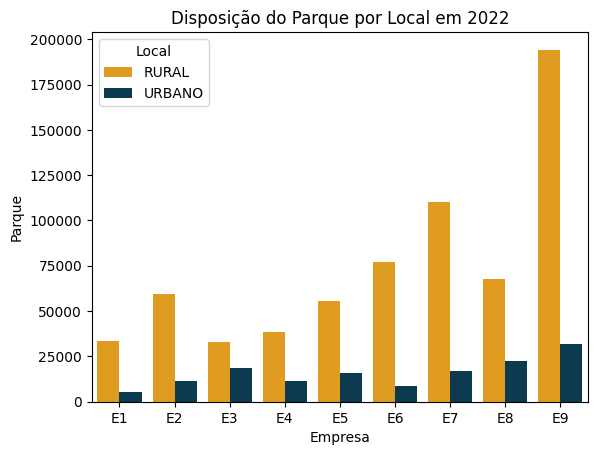

In [14]:
sns.barplot(data=parque_2022_local, x='Empresa', y='Parque', hue='Local', palette={'RURAL': '#ffa600', 'URBANO': '#003f5c'})

plt.xlabel('Empresa')
plt.ylabel('Parque')
plt.title('Disposição do Parque por Local em 2022')

plt.show()


In [15]:
clima_2022 = clima[(clima['Ano'] == 2022)]
clima_2022_empresa = clima_2022.groupby('Empresa')['Raio(NS)'].sum().reset_index()
clima_2022_empresa['Raio(NS)'] = clima_2022_empresa['Raio(NS)'].astype(int)
clima_2022_empresa

,Empresa,Raio(NS)
0,E1,1239799
1,E2,142920
2,E3,255200
3,E4,20385
4,E5,149953
5,E6,3191915
6,E7,3039031
7,E8,4301737
8,E9,8100642


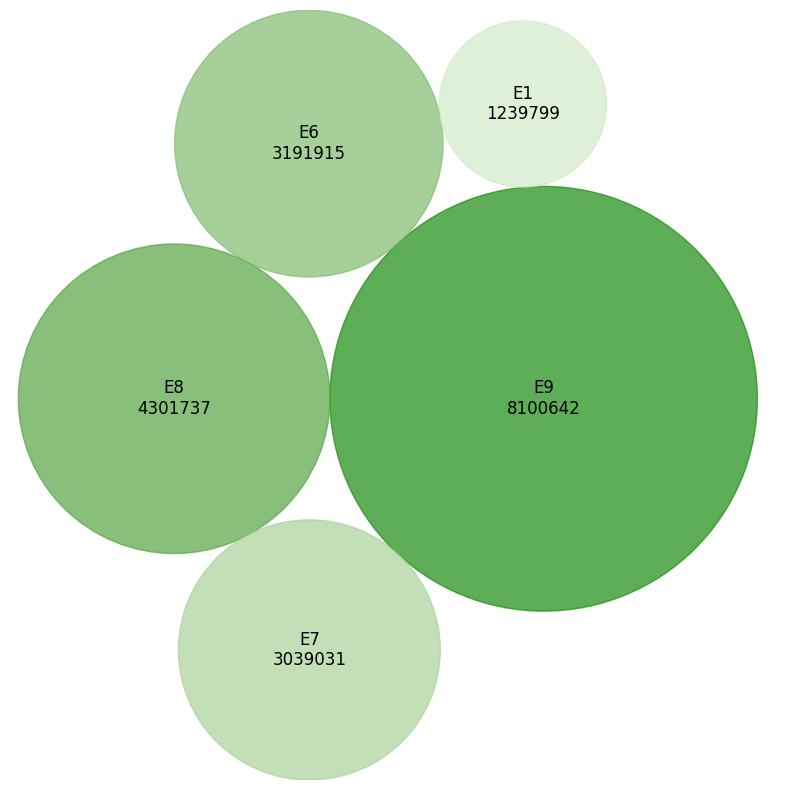

In [16]:
clima_2022_empresa.sort_values(by='Raio(NS)', ascending=False, inplace=True)

circles = circlify.circlify(clima_2022_empresa['Raio(NS)'].tolist(), show_enclosure=False, target_enclosure=circlify.Circle(x=0, y=0))
circles.reverse()

labels = [f'{region}<br>{ratio}' for region, ratio in zip(clima_2022_empresa['Empresa'], clima_2022_empresa['Raio(NS)'])]

color_palette = ['#198c0e', '#55a443', '#80bb6f', '#a9d29a', '#d1eac7']

fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax.axis('off')

lim = max(max(abs(circle.x) + circle.r, abs(circle.y) + circle.r) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

for circle, label, color in zip(circles, labels, color_palette):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.7, color=color))
    plt.annotate(label.replace('<br>', '\n'), (x, y), size=12, va='center', ha='center', color='black')

plt.show()

In [17]:
substituicao['DATA.OC'] = pd.to_datetime(substituicao['DATA.OC'], format='%d/%m/%Y')
substituicao['Mes'] = substituicao['DATA.OC'].dt.month

In [18]:
tipo = substituicao['SITUAÇÃO'].unique()
tipo

array(['QUEIMADO', 'AVARIADO', 'FURTADO', 'SOBRECARGA'], dtype=object)

In [19]:
substituicao_total = substituicao[(substituicao['SITUAÇÃO'] != 'FURTADO')]
substituicao_analise = substituicao_total.groupby(['Empresa', 'Ano', 'Mes']).size().reset_index(name='Falhas')
substituicao_analise

,Empresa,Ano,Mes,Falhas
0,E1,2021,1,69
1,E1,2021,2,73
2,E1,2021,3,81
3,E1,2021,4,63
4,E1,2021,5,60
...,...,...,...,...
257,E9,2023,1,273
258,E9,2023,2,261
259,E9,2023,3,251
260,E9,2023,4,250


In [20]:
clima_analise = clima.groupby(['Empresa', 'Ano', 'Mes'])[['Raio(NS)', 'Chuva']].sum().reset_index()
clima_analise['Raio(NS)'] = clima_analise['Raio(NS)'].astype(int)
clima_analise['Chuva'] = clima_analise['Chuva'].astype(int)
clima_analise = clima_analise[~((clima_analise['Ano'] == 2023) & (clima_analise['Mes'] >= 6))]
clima_analise

,Empresa,Ano,Mes,Raio(NS),Chuva
0,E1,2021,1,37444,643
1,E1,2021,2,124480,1073
2,E1,2021,3,48839,986
3,E1,2021,4,36085,465
4,E1,2021,5,21590,204
...,...,...,...,...,...
312,E9,2023,1,814869,1434
313,E9,2023,2,876829,555
314,E9,2023,3,317934,668
315,E9,2023,4,124786,124


In [21]:
clima_analise['Empresa'] = clima_analise['Empresa'].astype(str)
clima_analise['Ano'] = clima_analise['Ano'].astype(str)
clima_analise['Mes'] = clima_analise['Mes'].astype(str)
substituicao_analise['Empresa'] = substituicao_analise['Empresa'].astype(str)
substituicao_analise['Ano'] = substituicao_analise['Ano'].astype(str)
substituicao_analise['Mes'] = substituicao_analise['Mes'].astype(str)

In [22]:
falhas_clima = pd.merge(substituicao_analise, clima_analise, on=['Empresa', 'Ano', 'Mes'])

falhas_clima

,Empresa,Ano,Mes,Falhas,Raio(NS),Chuva
0,E1,2021,1,69,37444,643
1,E1,2021,2,73,124480,1073
2,E1,2021,3,81,48839,986
3,E1,2021,4,63,36085,465
4,E1,2021,5,60,21590,204
...,...,...,...,...,...,...
256,E9,2023,1,273,814869,1434
257,E9,2023,2,261,876829,555
258,E9,2023,3,251,317934,668
259,E9,2023,4,250,124786,124


In [26]:
falhas_clima['Falhas'] = pd.to_numeric(falhas_clima['Falhas'], errors='coerce')
falhas_clima['Raio(NS)'] = pd.to_numeric(falhas_clima['Raio(NS)'], errors='coerce')
falhas_clima['Chuva'] = pd.to_numeric(falhas_clima['Chuva'], errors='coerce')

falhas_clima = falhas_clima.dropna()

y = falhas_clima['Falhas']
X = falhas_clima[['Chuva', 'Raio(NS)']]
X = sm.add_constant(X) 

regression_model = sm.OLS(y, X)
regression_results = regression_model.fit()

print(regression_results.summary())

vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors:")
print(vif)

p_values = regression_results.pvalues
print("P-values:")
print(p_values)

                            OLS Regression Results                            
Dep. Variable:                 Falhas   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     251.1
Date:                Mon, 03 Jul 2023   Prob (F-statistic):           2.83e-61
Time:                        15:18:37   Log-Likelihood:                -1449.3
No. Observations:                 261   AIC:                             2905.
Df Residuals:                     258   BIC:                             2915.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.5780      5.420     16.342      0.0

In [27]:
parque_novo = parque[(parque['MES'] == 12) & (parque['LOCAL'] != 'INVALIDO')]
parque_ano = parque_novo.groupby(['Empresa', 'LOCAL', 'Ano'])['PARQUE.INSTALADO'].sum().reset_index()
parque_ano.columns = ['Empresa', 'Local', 'Ano', 'Parque']
parque_ano.head()

,Empresa,Local,Ano,Parque
0,E1,RURAL,2021,32862
1,E1,RURAL,2022,33707
2,E1,URBANO,2021,5185
3,E1,URBANO,2022,5373
4,E2,RURAL,2021,58422


In [28]:
substituicao_novo = substituicao[(substituicao['Ano'] != '2023') & (substituicao['LOCAL'] != 'INVALIDO')]
substituicao_ano = substituicao_novo[['Empresa', 'LOCAL', 'Ano']].value_counts().reset_index()
substituicao_ano.columns = ['Empresa', 'Local', 'Ano', 'Falhas']
substituicao_ano.head()

,Empresa,Local,Ano,Falhas
0,E9,RURAL,2021,2649
1,E9,RURAL,2022,2623
2,E8,RURAL,2022,2059
3,E6,RURAL,2022,2034
4,E8,RURAL,2021,2002


In [29]:
ist_ano = pd.merge(substituicao_ano, parque_ano, on=['Empresa', 'Local', 'Ano'])
ist_ano['ist'] = ist_ano['Falhas'] / ist_ano['Parque']
ist_ano.head()

,Empresa,Local,Ano,Falhas,Parque,ist
0,E9,RURAL,2021,2649,188271,0.014070
1,E9,RURAL,2022,2623,194190,0.013507
2,E8,RURAL,2022,2059,67577,0.030469
3,E6,RURAL,2022,2034,76811,0.026481
4,E8,RURAL,2021,2002,65852,0.030402


In [30]:
dummies = pd.get_dummies(ist_ano['Local'])
data_new = pd.concat([ist_ano, dummies], axis = 1)
data_new.drop(['Local'], axis = 1, inplace = True)

In [31]:
## tirando uma das opções de local para não cair no problema de multicolinearidade perfeita
data_new.drop(['RURAL'], inplace=True, axis = 1)

In [32]:
y = data_new['ist']
X = data_new['URBANO']
X = sm.add_constant(X)

regression_model = sm.OLS(y, X)
regression_results = regression_model.fit()

print(regression_results.summary())

p_values = regression_results.pvalues
print("P-values:")
print(p_values)

                            OLS Regression Results                            
Dep. Variable:                    ist   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     5.014
Date:                Mon, 03 Jul 2023   Prob (F-statistic):             0.0322
Time:                        15:18:51   Log-Likelihood:                 121.90
No. Observations:                  34   AIC:                            -239.8
Df Residuals:                      32   BIC:                            -236.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0171      0.002     10.213      0.0